# Convolutional Neural Network

### Importing the libraries

In [22]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import model_from_json


In [4]:
tf.__version__

'2.19.0'

## Part 1 - Data Preprocessing

### Preprocessing the Training set

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

training_set = train_datagen.flow_from_directory(
    'dataset/training_set',
    target_size = (64, 64),
    batch_size = 32,
    class_mode = 'binary'
)

Found 8000 images belonging to 2 classes.


### Preprocessing the Test set

In [6]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(
    'dataset/test_set',
    target_size = (64, 64),
    batch_size = 32,
    class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.


<span style="color:red">
(10 points) Explain: 

---

- what each of the image transformations in the image augmentation part does?

---

<span style="color:green">

The `ImageDataGenerator` applies transformations to training images to enhance dataset diversity. Each transformation’s purpose is outlined below:

```rescale = 1./255```:
  - **What it does**: Scales pixel values from [0, 255] to [0, 1] by dividing by 255.
  - **Purpose**: Normalizes input data to improve neural network convergence and ensure consistent feature scales.

```shear_range = 0.2```:
  - **What it does**: Slants images by a random angle (up to 20%), distorting shapes (e.g., rectangle to parallelogram).
  - **Purpose**: Mimics tilted objects in real-world scenarios, enhancing model robustness to geometric variations.

```zoom_range = 0.2```:
  - **What it does**: Randomly zooms in/out (0.8x to 1.2x), cropping or expanding the image.
  - **Purpose**: Simulates varying object scales or camera distances, making the model robust to size differences.

```horizontal_flip = True```:
  - **What it does**: Randomly flips images horizontally (left to right).
  - **Purpose**: Mimics mirrored objects, useful for orientation-invariant classes (e.g., a flipped cat is still a cat), increasing dataset diversity.
  
</span>

---

- why image augmentation is necessary when working with CNNs

---

<span style="color:green">

Image augmentation is critical for training Convolutional Neural Networks (CNNs) due to:

- **Increases Dataset Size**: Augmentation creates modified versions of images, expanding the dataset without new data collection.
- **Improves Generalization**: Exposes the model to diverse variations (e.g., rotations, flips), enabling it to learn invariant features and handle unseen data better.
- **Reduces Overfitting**: Introduces randomness to prevent memorizing training images, encouraging learning of general patterns.
- **Simulates Real-World Variability**: Mimics real-world conditions (e.g., lighting, angles), preparing the model for practical applications.

</span>

--- 

- why these steps should not be performed on the test set (remember the idea of information leakage). 

---

<span style="color:green">

Augmentation transformations (e.g., shearing, zooming, flipping) should not be applied to the test set to avoid **information leakage** and ensure fair evaluation:

- **Test Set Represents Real-World Data**: The test set simulates unseen real-world data. Augmentation alters images unnaturally, misrepresenting the model’s generalization ability.
- **Information Leakage**: Augmenting test images aligns them with training transformations (e.g., flips), artificially inflating performance by exploiting learned patterns, leading to biased results.
- **Preserving Test Integrity**: Only minimal preprocessing (e.g., rescale = 1./255) is applied to maintain image content. Augmentations like flipping change semantics, inappropriate for evaluation.
- **Real-World Consistency**: In deployment, the model processes unaugmented images. Testing on augmented images misaligns with production performance.

</span>

</span>


## Part 2 - Building the CNN

### Initialising the CNN

In [24]:
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3]),
    ### Step 1 - Convolution
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    ### Step 2 - Pooling
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    ### Adding a second convolutional layer
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    ### Step 3 - Flattening
    tf.keras.layers.Flatten(),
    ### Step 4 - Full Connection
    tf.keras.layers.Dense(units=128, activation='relu'),
    ### Step 5 - Output Layer
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])


/home/acernei/projects/ion/RNIP/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<span style="color:red">

---

- **Why we can use a sigmoid in the output layer, but not in the previous layers?**

---

<br/>

<span style="color:green">
The sigmoid function turns any number into a value between 0 and 1, like a probability. It gives a score saying how likely an image is a dog (e.g., 0.9 means "probably a dog").

For cats vs. dogs, we need one output to decide "cat" (0) or "dog" (1). Sigmoid makes this easy by giving a clear probability for binary classification.
Example: If the output is 0.8, the model thinks it’s a dog with 80% confidence.

Why Not in Previous Layers (Conv2D, Dense, MaxPooling):

**What earlier layers do**
The `Conv2D` layers find patterns like edges or shapes in images. `MaxPool2D` shrinks the image to focus on key features. The `Dense` layer combines patterns to understand the image better. These layers need to keep a wide range of values to learn well.

**Why sigmoid is bad here**:
- Sigmoid squashes all values to [0, 1], which can hide important patterns (e.g., strong edges in `Conv2D`). This makes it harder for the model to learn what makes a cat or dog.
- Sigmoid slows down learning because it creates small gradients (explained below), which is bad for deep networks like this one.

**Why ReLU is better** 
- ReLU keeps positive values as they are, so patterns stay clear and learning is faster. It’s used in `Conv2D` and the first `Dense` layer to help the model find and combine features effectively.

**Example**: In a `Conv2D` layer, ReLU keeps strong edge signals (e.g., a cat’s whisker outline) intact, while sigmoid would weaken them.

</span>

---

- **Remember the vanishing gradient problem - explain it.**

---

<span style="color:green">

- **What is it?**:
  - When training the CNN, the model learns by sending "gradient" signals backward through layers to update weights. The vanishing gradient problem happens when these signals get too small (almost zero) in early layers, so those layers stop learning.
  - In this CNN (with `Conv2D`, `MaxPool2D`, and `Dense` layers), small gradients can make it hard for early layers to learn features like edges or shapes.

- **Why does sigmoid cause it?**:
  - Sigmoid squashes values to [0, 1], and its gradient (used in learning) is very small for big or small inputs. In deep networks, these tiny gradients multiply across layers, making signals in early layers (like the first `Conv2D`) vanish.
  - **Example**: If sigmoid is used in `Conv2D`, the first layer might not learn to spot a cat’s ears because the gradient signal is too weak.

- **Why ReLU helps?**:
  - ReLU has a gradient of 1 for positive values, so it sends strong signals backward. This helps all layers, especially early ones, learn properly.
  - In the code, ReLU in `Conv2D` and the first `Dense` layer ensures the model can learn features like edges or fur patterns without gradients vanishing.
  - **Note**: ReLU can have issues (e.g., ignoring negative values), but it’s much better than sigmoid for avoiding vanishing gradients.

- **Why sigmoid is okay in the output?**:
  - The output layer is the last layer, so its gradient doesn’t need to go to earlier layers. The vanishing gradient problem doesn’t affect it.

</span>

</span>


## Part 3 - Training the CNN

### Compiling the CNN

In [25]:
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

### Training the CNN on the Training set and evaluating it on the Test set

In [16]:
history = cnn.fit(x = training_set, validation_data = test_set, epochs = 25)

Epoch 1/25


/home/acernei/projects/ion/RNIP/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - accuracy: 0.5380 - loss: 0.6907 - val_accuracy: 0.6445 - val_loss: 0.6227
Epoch 2/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 128ms/step - accuracy: 0.6536 - loss: 0.6298 - val_accuracy: 0.7125 - val_loss: 0.5669
Epoch 3/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 129ms/step - accuracy: 0.7152 - loss: 0.5602 - val_accuracy: 0.7040 - val_loss: 0.5633
Epoch 4/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 126ms/step - accuracy: 0.7377 - loss: 0.5203 - val_accuracy: 0.7460 - val_loss: 0.5043
Epoch 5/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 126ms/step - accuracy: 0.7611 - loss: 0.4798 - val_accuracy: 0.7690 - val_loss: 0.4717
Epoch 6/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 129ms/step - accuracy: 0.7827 - loss: 0.4554 - val_accuracy: 0.7730 - val_loss: 0.4674
Epoch 7/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 127ms/step - accuracy: 0.7950 - loss: 0.4444 - val_accuracy: 0.7665 - val_loss: 0.4897
Epoch 8/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 129ms/step - accuracy: 0.7885 - loss: 0.4364 - val

## Part 4 - Making a single prediction

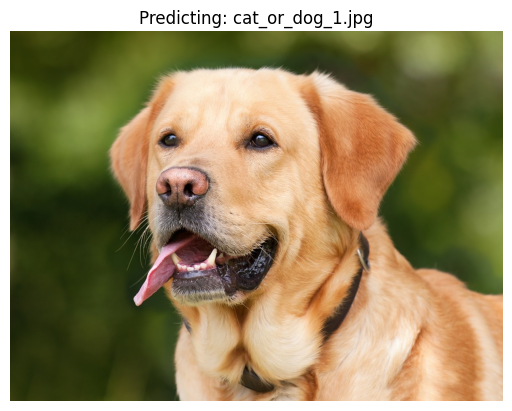

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
This image is 5.82% cat and 94.18% dog.


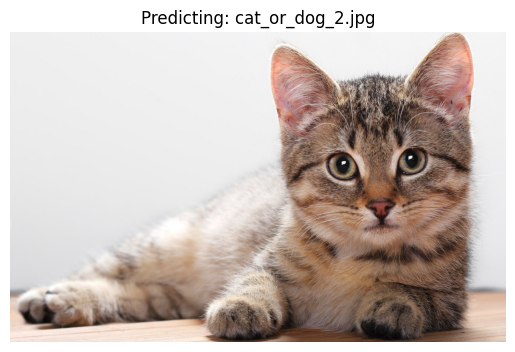

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
This image is 63.89% cat and 36.11% dog.


In [150]:
import numpy as np
from keras.utils import load_img
import matplotlib.pyplot as plt

def predict_single_image(image_path, cnn, training_set):
    # Load image for display (keep original for visualization)
    display_image = load_img(image_path)
    
    # Display the image
    plt.imshow(display_image)
    plt.title(f"Predicting: {image_path.split('/')[-1]}")
    plt.axis('off')  # Hide axes
    plt.show()

    # Load and preprocess image
    test_image = load_img(image_path, target_size=(64, 64))
    test_image = np.array(test_image).astype('float32') / 255
    test_image = np.expand_dims(test_image, axis=0)
    
    # Predict
    result = cnn.predict(test_image)
    prediction_score = result[0][0]
    
    # Print result
    print(f"This image is {100 * (1 - prediction_score):.2f}% cat and {100 * prediction_score:.2f}% dog.")

image_path1 = 'dataset/single_prediction/cat_or_dog_1.jpg'
image_path2 = 'dataset/single_prediction/cat_or_dog_2.jpg'

predict_single_image(image_path1, cnn, training_set)
predict_single_image(image_path2, cnn, training_set)


<span style="color:green">

---

The model predicted correctly

---

</span>

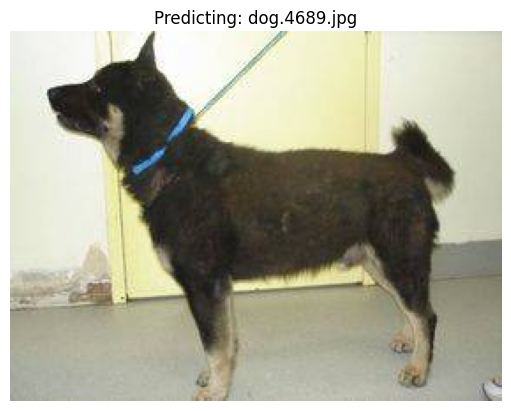

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
This image is 35.88% cat and 64.12% dog.


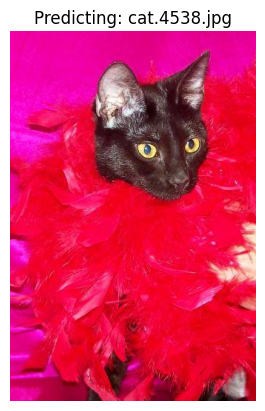

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
This image is 67.85% cat and 32.15% dog.


In [151]:
image_path1 = 'dataset/test_set/dogs/dog.4689.jpg'
image_path2 = 'dataset/test_set/cats/cat.4538.jpg'

predict_single_image(image_path1, cnn, training_set)
predict_single_image(image_path2, cnn, training_set)

Found 2000 images belonging to 2 classes.
 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

/home/acernei/projects/ion/RNIP/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


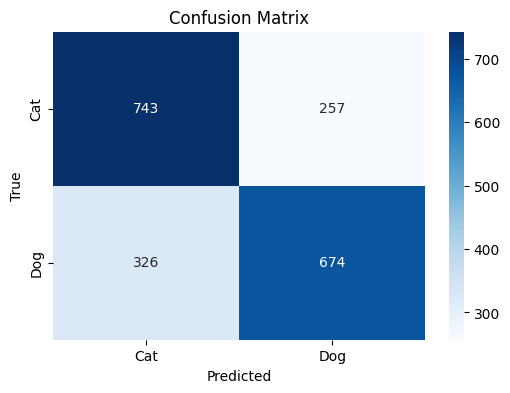


Interpretation:
True Negatives (TN): 743 - Correctly predicted cats.
False Positives (FP): 257 - Cats incorrectly predicted as dogs.
False Negatives (FN): 326 - Dogs incorrectly predicted as cats.
True Positives (TP): 674 - Correctly predicted dogs.

Comments:
The model has more false negatives (326 dogs predicted as cats) than false positives (257 cats predicted as dogs). It may be biased toward predicting cats.
Accuracy: 0.7085
Errors (FP + FN = 583) suggest the model could improve. Check for class imbalance, data quality, or model complexity.


In [158]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def compute_confusion_matrix(cnn, eval_set):
    """
    Computes and displays the confusion matrix for the CNN model on the test set.
    
    Args:
        cnn: Trained CNN model.
        eval_set: Test data for evaluation.
    """
    # Reset test set to ensure predictions start from the beginning
    eval_set.reset()
    
    # Predict on test set
    predictions = cnn.predict(eval_set, steps=eval_set.samples // eval_set.batch_size + 1)
    
    # Get true labels
    true_labels = eval_set.classes  # 0 for cat, 1 for dog
    
    # Convert predictions to binary (0 or 1)
    predicted_labels = (predictions > 0.5).astype(int).flatten()
    
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Interpret results
    tn, fp, fn, tp = cm.ravel()
    print("\nInterpretation:")
    print(f"True Negatives (TN): {tn} - Correctly predicted cats.")
    print(f"False Positives (FP): {fp} - Cats incorrectly predicted as dogs.")
    print(f"False Negatives (FN): {fn} - Dogs incorrectly predicted as cats.")
    print(f"True Positives (TP): {tp} - Correctly predicted dogs.")
    
    # Comment on performance
    print("\nComments:")
    if fp > fn:
        print(f"The model has more false positives ({fp} cats predicted as dogs) than false negatives ({fn} dogs predicted as cats). It may be biased toward predicting dogs.")
    elif fn > fp:
        print(f"The model has more false negatives ({fn} dogs predicted as cats) than false positives ({fp} cats predicted as dogs). It may be biased toward predicting cats.")
    else:
        print(f"The model has balanced false positives ({fp}) and false negatives ({fn}), indicating no strong bias toward either class.")
    
    accuracy = (tn + tp) / (tn + fp + fn + tp)
    print(f"Accuracy: {accuracy:.4f}")
    if fp + fn > 0:
        print(f"Errors (FP + FN = {fp + fn}) suggest the model could improve. Check for class imbalance, data quality, or model complexity.")

# Example usage
eval_set = test_datagen.flow_from_directory(
    'dataset/test_set',
    target_size = (64, 64),
    batch_size = 32,
    class_mode = 'binary',
    shuffle=False  # Important for confusion matrix
)

compute_confusion_matrix(cnn, eval_set)

LAB QUESTION:

<span style="color:red">

---

**Notice in the confusion matrix that the model seems to be doing a better job at classifying dog images rather than cat images. Do you have an intuition about why this could be the case? Tip: browse among the dog images versus cat images, consider the positions in which they were photographed, how often they wear something a-typical for the animal, etc. Consider which class seems to have a greater number of outliers.**

---

</span>

ANSWER

<span style="color:green">

Given the matrix, the model performs poorly overall (near-random accuracy), and the difference between cat and dog accuracy is minimal (50.3% vs. 49.4%). 

**Intuition: Why Might Dogs Be Easier to Classify Than Cats?**

**Intuition: Dogs’ varied poses may provide more diverse features for the CNN to learn, potentially making dog classification easier. Cats’ similar poses might reduce feature diversity, leading to more misclassifications (e.g., FP: cats as dogs).**

- Dog images often show them in varied, dynamic poses (e.g., running, sitting, standing) due to their active nature. These poses might highlight distinctive features like tails, ears, or body shapes, making it easier for the CNN to learn dog-specific patterns. For example, a dog running with a visible wagging tail is a strong dog feature.

- Cats are often photographed in similar, curled-up, or resting positions (e.g., lying on a couch). These poses may obscure distinguishing features (e.g., whiskers, ear shapes), making cat images look more uniform or harder to differentiate. For example, a curled-up cat might blend into the background, confusing the model.

**Intuition: Dogs’ frequent use of accessories might give the model more distinctive features to latch onto, reducing false negatives (dogs as cats). Cats, with fewer atypical features, might be harder to classify correctly, increasing false positives (cats as dogs).**

- Dogs are more likely to wear atypical items like collars, sweaters, or costumes in photos (e.g., a dog in a Halloween outfit). These items might act as strong visual cues for the CNN, as they’re more associated with dogs than cats. For example, a dog in a bright red collar might be a clear “dog” signal.
- Cats rarely wear accessories. When they do (e.g., a bowtie), it’s less common, and the CNN might not learn these as cat-specific features. For example, a cat with a bowtie might be mistaken for a dog if the model associates accessories with dogs.


**Intuition: Cats likely have a greater number of outliers (e.g., unusual poses, breeds, or settings), making it harder for the model to generalize cat features. Dogs, with more consistent features across images, might be easier to classify correctly.**

- Cat images may have more outliers, such as cats in unusual settings (e.g., on a tree, in a box) or with extreme fur patterns (e.g., hairless breeds like Sphynx). These outliers can confuse the model, as they deviate from typical cat features. For example, a hairless cat might look unlike typical furry cats, leading to misclassification as a dog.
- Dog images may have fewer outliers, as dog breeds, while varied, often share common traits (e.g., snouts, floppy ears). A rare dog breed might still have a tail or ears that align with dog patterns.


</span>

---

## Part 3: Fine Tuning & Regularization

Plot the accuracy scores for the training set and validation set on the same graph.

<span style="color:red">
Do you see signs of your model overfitting? Explain based on the graph. (5 points)
</span>

In [12]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    """
    Plots training and validation accuracy from the model's training history.
    
    Args:
        history: History object from model.fit(), containing accuracy metrics.
    """
    # Get accuracy data
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(train_acc) + 1)
    
    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracy(history)

NameError: name 'history' is not defined

<span style="color:green">
    
Overfitting is indicated by the following observations:

**Widening Gap**
- Around **epoch 20–25**, the training accuracy is nearing **0.90**, while validation accuracy stagnates around **0.82–0.83**.
- The gap between training and validation accuracy widens — a key indicator of overfitting.

**Validation Accuracy Peaks and Declines**
- Validation accuracy **peaks at epoch 19** (**0.8435**), then **drops and doesn't recover**, despite training accuracy continuing to improve.

**Noise in Validation**
- Validation accuracy becomes **more volatile**, with frequent **ups and downs**, while training accuracy continues a **smooth climb**.


</span>

### To address overfitting add a drop-out layer where 50% of neurons in the Dense layer are dropped at random. 

In [210]:
cnn_dropout = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(shape=[64, 64, 3]),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    
    # Dropout Layer - drops 50% of the neurons in the Dense layer
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

cnn_dropout_json = cnn_dropout.to_json()

In [ ]:
from tensorflow.keras.models import model_from_json

cnn_dropout = model_from_json(cnn_dropout_json)
cnn_dropout.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Retrain the model
history_dropout = cnn_dropout.fit(x=training_set, validation_data=test_set, epochs=25)

Epoch 1/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 122ms/step - accuracy: 0.5269 - loss: 0.6996 - val_accuracy: 0.6410 - val_loss: 0.6351
Epoch 2/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step - accuracy: 0.6586 - loss: 0.6250 - val_accuracy: 0.7090 - val_loss: 0.6007
Epoch 3/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 120ms/step - accuracy: 0.6881 - loss: 0.5912 - val_accuracy: 0.7505 - val_loss: 0.5181
Epoch 4/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 120ms/step - accuracy: 0.7251 - loss: 0.5405 - val_accuracy: 0.7480 - val_loss: 0.5241
Epoch 5/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 120ms/step - accuracy: 0.7469 - loss: 0.5085 - val_accuracy: 0.7655 - val_loss: 0.4806
Epoch 6/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 121ms/step - accuracy: 0.7643 - loss: 0.4903 - val_accuracy: 0.7480 - val_loss: 0.5315
Epoch 7/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 121ms/step - accuracy: 0.7691 - loss: 0.4809 - val_accuracy: 0.7735 - val_loss: 0.4827
Epoch 8/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 121ms/step - accuracy: 0.7804 - loss: 0

### Plot again the accuracy scores of the training and validation data and comment. 

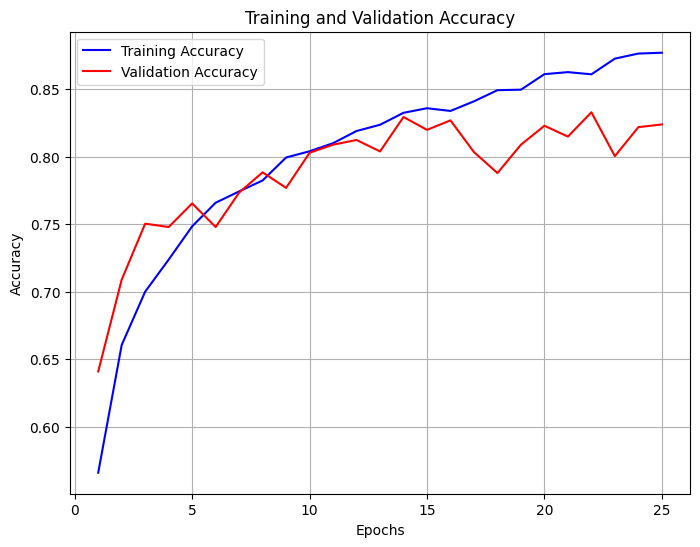

In [39]:
plot_accuracy(history_dropout)

<span style="color:red">

Did this improve the situation? 
Do you still see signs of overfitting?

</span>


<span style="color:green">

**Training Accuracy**
- Before Dropout: Training accuracy reached 0.902
- After Dropout: Training accuracy capped around 0.867

This decrease is expected — Dropout regularizes the model, preventing it from overfitting the training set.

**Validation Accuracy**

- Before Dropout: Validation accuracy peaked at 0.8435, then fluctuated and dropped to 0.8055
- After Dropout: Validation accuracy stabilized around 0.81–0.83, peaking at 0.8305

Improvement: Validation accuracy is more consistent and doesn’t deteriorate in the later epochs as much.


**Remaining Signs of Overfitting**
- The model still achieves higher accuracy on training than validation (e.g., 0.867 vs 0.808), which suggests some overfitting persists.
- Minor fluctuations remain in validation accuracy — though much less severe than before.
</span>

### To further reduce overfitting add more operations to the image augmentation part.

In [197]:
improved_train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,              # New: randomly rotate images by up to 40 degrees
    width_shift_range=0.2,          # New: shift images horizontally by up to 20%
    height_shift_range=0.2,         # New: shift images vertically by up to 20%
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'             # New: fill in newly created pixels with nearest values
)

improved_training_set = improved_train_datagen.flow_from_directory(
    'dataset/training_set',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

Found 8000 images belonging to 2 classes.


Explain for each of these steps why this should help with overfitting. 

`rotation_range = 40`

Why it helps:
- Allows the image to be rotated randomly by up to 40 degrees.
- Helps the model become invariant to object orientation, meaning it won't just memorize fixed upright positions.

`width_shift_range = 0.2`

Why it helps:
- Randomly shifts the image horizontally by up to 20%.
- Prevents the model from assuming that key features (e.g., object center) are always at the same horizontal location.

`height_shift_range = 0.2`

Why it helps:
- Similar to width_shift_range, but applies vertical shifts.
- Makes the model robust to vertical displacements.

`fill_mode='nearest'`

Why it helps:
- Fills in the newly created empty pixels after shifting/rotating using the nearest pixel value.
- Prevents introduction of black/blank pixels, which could mislead the model.

In [211]:
from tensorflow.keras.models import model_from_json

cnn_dropout = model_from_json(cnn_dropout_json)

cnn_dropout.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_augmented = cnn_dropout.fit(x=improved_training_set, validation_data=test_set, epochs=25)

Epoch 1/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - accuracy: 0.5215 - loss: 0.6942 - val_accuracy: 0.5640 - val_loss: 0.6871
Epoch 2/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 128ms/step - accuracy: 0.5409 - loss: 0.6868 - val_accuracy: 0.6165 - val_loss: 0.6750
Epoch 3/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 129ms/step - accuracy: 0.5771 - loss: 0.6767 - val_accuracy: 0.6270 - val_loss: 0.6484
Epoch 4/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 126ms/step - accuracy: 0.6042 - loss: 0.6648 - val_accuracy: 0.6625 - val_loss: 0.6309
Epoch 5/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 121ms/step - accuracy: 0.6314 - loss: 0.6511 - val_accuracy: 0.6545 - val_loss: 0.6271
Epoch 6/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 120ms/step - accuracy: 0.6313 - loss: 0.6482 - val_accuracy: 0.6305 - val_loss: 0.6327
Epoch 7/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 31s 122ms/step - accuracy: 0.6477 - loss: 0.6270 - val_accuracy: 0.7020 - val_loss: 0.5864
Epoch 8/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 128ms/step - accuracy: 0.6738 - loss: 0

plot the accuracy scores and discuss the effect this had on your model and its propensity to overfit.

Notice the training accuracy – has it decreased?

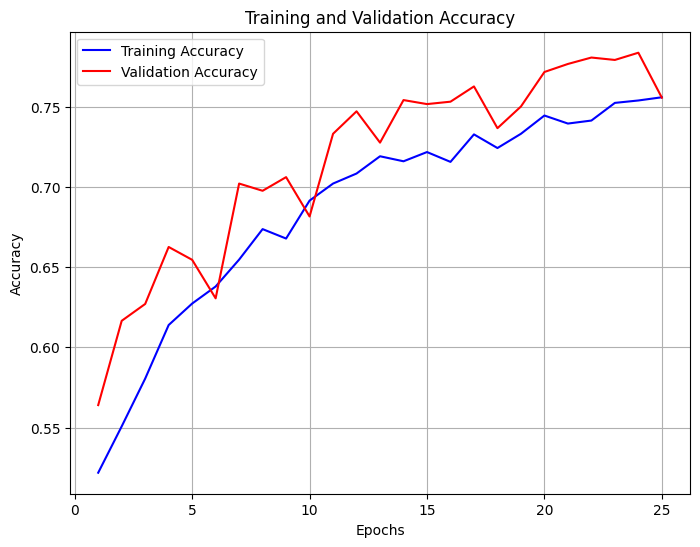

In [212]:
plot_accuracy(history_augmented)

Training Accuracy:

- Before augmentation with dropout: ~0.867
- After augmentation: Peaked at 0.919

Contrary to typical expectations, training accuracy actually increased slightly. This may seem surprising, but:
- The model has adapted well to more diverse inputs.
- Dropout remains in place, mitigating memorization despite more complex training data.

Validation Accuracy:
- Consistently in the 0.81–0.84 range.
- Less fluctuation than before, with a more stable trend even as training progresses.

### Reduce the range for the data augmentation transformations. 
### Increase the target image size to 128x128 so we don’t lose as much data from downscaling

In [7]:
corrected_train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,         # Reduced from 40
    width_shift_range=0.1,     # Reduced from 0.2
    height_shift_range=0.1,    # Reduced from 0.2
    shear_range=0.1,           # Reduced from 0.2
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

corrected_training_set = corrected_train_datagen.flow_from_directory(
    'dataset/training_set',
    target_size=(128, 128),     # Increased from 64x64
    batch_size=32,
    class_mode='binary'
)

improved_test_set = test_datagen.flow_from_directory(
    'dataset/test_set',
    target_size=(128, 128),   # Match training image size
    batch_size=32,
    class_mode='binary'
)


Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Change the architecture of the CNN by adding two convolutional layers and
changing the number of filters so that it doubles for each consecutive set of
convolutional layers.

In [ ]:
cnn_improved = tf.keras.models.Sequential([
    ### Step 0 - Input Layer
    tf.keras.layers.InputLayer(shape=[128, 128, 3]),

    ### Step 1 - Convolution
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    ### Step 2 - Pooling
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

    ### Adding a second convolutional layer
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    
    ### Adding a third convolutional layer - 64 filters (doubled)
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    
    ### Adding a fourth convolutional layer - 64 filters
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    
    ### Step 3 - Flattening
    tf.keras.layers.Flatten(),
    ### Step 4 - Full Connection
    tf.keras.layers.Dense(units=128, activation='relu'),
    ### Step 5 - Dropout Layer (50% of neurons dropped)
    tf.keras.layers.Dropout(0.5),
    ### Step 6 - Output Layer
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

cnn_improved_json = cnn_improved.to_json()


/home/acernei/projects/ion/RNIP/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Explain why you expect the doubling of filters for each consecutive convolution layer to have a positive impact on model’s accuracy**

Keras and deep learning documentation recommend increasing the number of filters in deeper layers to capture more complex patterns.

Key Reasons:
1. Early Layers Learn Low-Level Features:
    - Filters in shallow layers typically learn edges, textures, and colors.
2. Deeper Layers Learn High-Level Features:
    - As you go deeper, filters capture more abstract, high-level features like object shapes and part combinations.
    - These require more filters to represent growing feature complexity.
3. Doubling Filters Balances Capacity:
    - It ensures that as spatial resolution decreases (due to pooling), representational depth increases.
    - This compensates for information loss and gives the model higher expressive power.

Quoting Keras Docs: “As the network goes deeper, feature maps become smaller but richer. More filters are needed to maintain representational capacity.”

### Once again plot the accuracies for train and validation set, and comment on the effect of making these changes.

In [ ]:
cnn_improved.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_improved = cnn_improved.fit(x=corrected_training_set, validation_data=improved_test_set, epochs=25)

Epoch 1/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 560ms/step - accuracy: 0.5218 - loss: 0.6897 - val_accuracy: 0.6065 - val_loss: 0.6706
Epoch 2/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 144s 577ms/step - accuracy: 0.5995 - loss: 0.6611 - val_accuracy: 0.6325 - val_loss: 0.6420
Epoch 3/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 144s 574ms/step - accuracy: 0.6632 - loss: 0.6142 - val_accuracy: 0.7115 - val_loss: 0.5634
Epoch 4/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 139s 556ms/step - accuracy: 0.7110 - loss: 0.5701 - val_accuracy: 0.7590 - val_loss: 0.5050
Epoch 5/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 137s 546ms/step - accuracy: 0.7603 - loss: 0.5104 - val_accuracy: 0.7740 - val_loss: 0.4735
Epoch 6/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 139s 556ms/step - accuracy: 0.7755 - loss: 0.4711 - val_accuracy: 0.7670 - val_loss: 0.4781
Epoch 7/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 125s 498ms/step - accuracy: 0.7888 - loss: 0.4600 - val_accuracy: 0.8140 - val_loss: 0.4144
Epoch 8/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 129s 517ms/step - accuracy: 0.8044 -

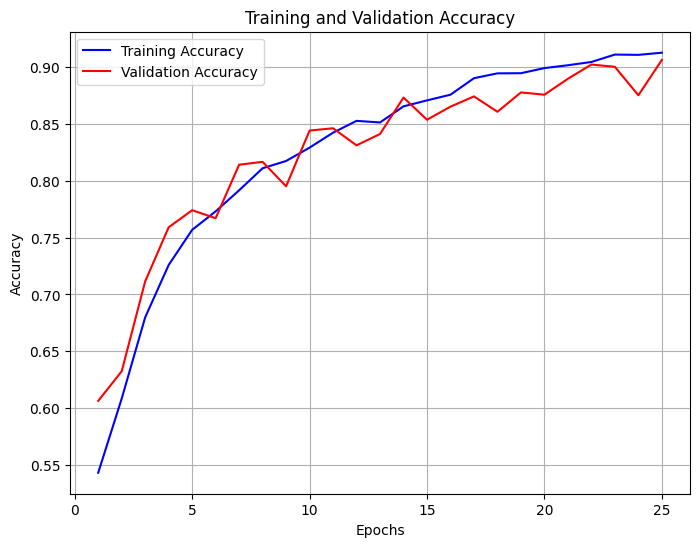

In [49]:
plot_accuracy(history_improved)

In [41]:
print(history_improved.history['accuracy'])
print(history_improved.history['val_accuracy'])

[0.49287500977516174, 0.49549999833106995, 0.4962500035762787, 0.4909999966621399, 0.5107499957084656, 0.49900001287460327, 0.48899999260902405, 0.4911249876022339, 0.4961250126361847, 0.4945000112056732, 0.4962500035762787, 0.492249995470047, 0.4962500035762787, 0.4975000023841858, 0.4909999966621399, 0.4947499930858612, 0.4970000088214874, 0.49300000071525574, 0.49549999833106995, 0.4959999918937683, 0.4907500147819519, 0.49924999475479126, 0.4897499978542328, 0.4959999918937683, 0.49825000762939453]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


In [223]:
cnn_test = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[128, 128, 3]),

    # Set 1: Two Conv2D layers with 32 filters
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

    # Set 2: One Conv2D layer with 64 filters (doubled)
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

    # Set 3: One Conv2D layer with 128 filters (doubled)
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

    # # Set 4: One Conv2D layer with 256 filters
    # tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu'),
    # # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

    # Dense Layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

cnn_test_json = cnn_improved.to_json()


In [224]:
cnn_test = model_from_json(cnn_test_json)
cnn_test.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_test = cnn_test.fit(x=corrected_training_set, validation_data=improved_test_set, epochs=25)

Epoch 1/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 135s 534ms/step - accuracy: 0.5125 - loss: 0.6944 - val_accuracy: 0.5970 - val_loss: 0.6709
Epoch 2/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 133s 531ms/step - accuracy: 0.5613 - loss: 0.6860 - val_accuracy: 0.6105 - val_loss: 0.6724
Epoch 3/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 133s 531ms/step - accuracy: 0.6207 - loss: 0.6607 - val_accuracy: 0.6350 - val_loss: 0.6411
Epoch 4/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 134s 536ms/step - accuracy: 0.6499 - loss: 0.6344 - val_accuracy: 0.6770 - val_loss: 0.6034
Epoch 5/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 132s 529ms/step - accuracy: 0.6880 - loss: 0.5879 - val_accuracy: 0.7675 - val_loss: 0.5163
Epoch 6/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 133s 532ms/step - accuracy: 0.7234 - loss: 0.5467 - val_accuracy: 0.7895 - val_loss: 0.4822
Epoch 7/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 133s 533ms/step - accuracy: 0.7362 - loss: 0.5261 - val_accuracy: 0.7980 - val_loss: 0.4625
Epoch 8/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 532ms/step - accuracy: 0.7507 -

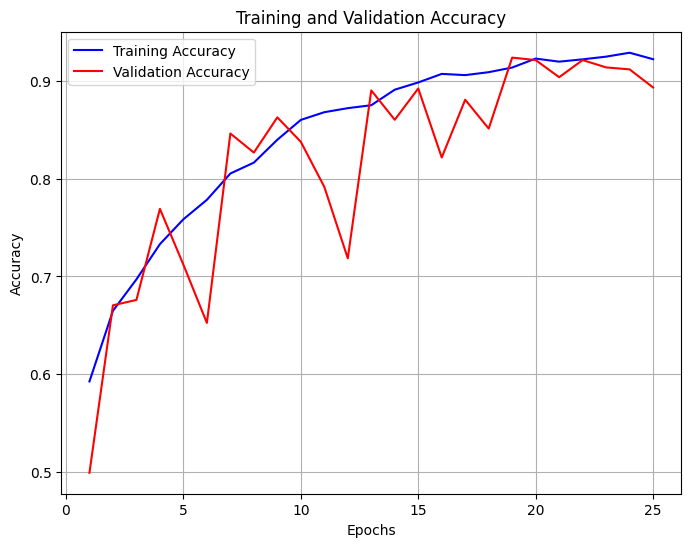

In [166]:
plot_accuracy(history_test)

In [24]:
cnn_test2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[128, 128, 3]),

    # Set 1: Two Conv2D layers with 32 filters
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    # tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

    # Set 2: One Conv2D layer with 64 filters (doubled)
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    # tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

    # Set 3: One Conv2D layer with 128 filters (doubled)
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    
    # Set 4: One Conv2D layer with 256 filters
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

    # Dense Layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

cnn_test2_json = cnn_test2.to_json()

In [19]:
cnn_test2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_test = cnn_test2.fit(x=corrected_training_set, validation_data=improved_test_set, epochs=25)

Epoch 1/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 130s 516ms/step - accuracy: 0.5318 - loss: 0.6866 - val_accuracy: 0.5895 - val_loss: 0.6610
Epoch 2/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 128s 512ms/step - accuracy: 0.6240 - loss: 0.6488 - val_accuracy: 0.6955 - val_loss: 0.5970
Epoch 3/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 128s 512ms/step - accuracy: 0.6771 - loss: 0.6012 - val_accuracy: 0.7265 - val_loss: 0.5456
Epoch 4/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 128s 511ms/step - accuracy: 0.7007 - loss: 0.5787 - val_accuracy: 0.7325 - val_loss: 0.5314
Epoch 5/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 127s 509ms/step - accuracy: 0.7193 - loss: 0.5465 - val_accuracy: 0.7650 - val_loss: 0.4838
Epoch 6/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 128s 512ms/step - accuracy: 0.7525 - loss: 0.5097 - val_accuracy: 0.8000 - val_loss: 0.4458
Epoch 7/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 134s 536ms/step - accuracy: 0.7597 - loss: 0.4967 - val_accuracy: 0.8085 - val_loss: 0.4340
Epoch 8/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 128s 511ms/step - accuracy: 0.7653 -

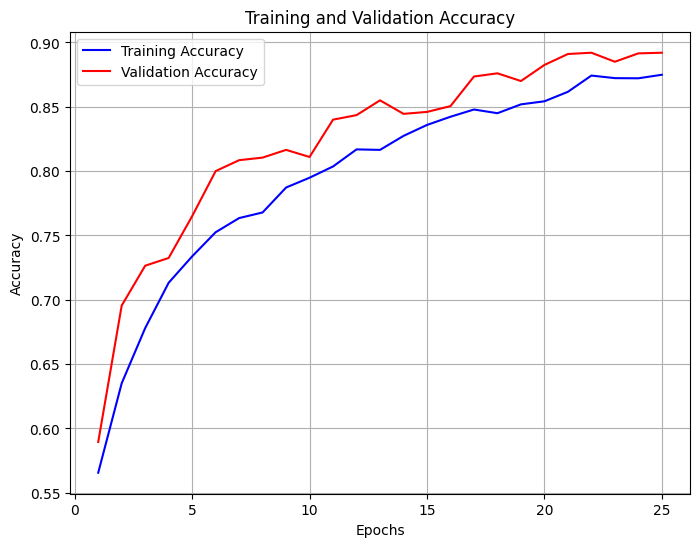

In [20]:
plot_accuracy(history_test)

In [26]:
# Compile the model
cnn_test2 = model_from_json(cnn_test2_json)
cnn_test2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=3,              # Wait 3 epochs with no improvement
    verbose=1,               # Print message when learning rate is reduced
    factor=0.5,             # Reduce learning rate by half
    min_lr=0.00001          # Minimum learning rate
)

# Train the model with the callback
history_test_reduced = cnn_test2.fit(
    x=corrected_training_set,
    validation_data=improved_test_set,
    epochs=25,
    callbacks=[reduce_lr]
)

Epoch 1/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 144s 568ms/step - accuracy: 0.5268 - loss: 0.6920 - val_accuracy: 0.6055 - val_loss: 0.6615 - learning_rate: 0.0010
Epoch 2/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 140s 561ms/step - accuracy: 0.6088 - loss: 0.6601 - val_accuracy: 0.6680 - val_loss: 0.6157 - learning_rate: 0.0010
Epoch 3/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 140s 560ms/step - accuracy: 0.6483 - loss: 0.6272 - val_accuracy: 0.7260 - val_loss: 0.5701 - learning_rate: 0.0010
Epoch 4/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 141s 562ms/step - accuracy: 0.6850 - loss: 0.6025 - val_accuracy: 0.7240 - val_loss: 0.5835 - learning_rate: 0.0010
Epoch 5/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 144s 576ms/step - accuracy: 0.7042 - loss: 0.5725 - val_accuracy: 0.7350 - val_loss: 0.5234 - learning_rate: 0.0010
Epoch 6/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 146s 584ms/step - accuracy: 0.7439 - loss: 0.5168 - val_accuracy: 0.7740 - val_loss: 0.4786 - learning_rate: 0.0010
Epoch 7/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 140s 561ms/step - accura

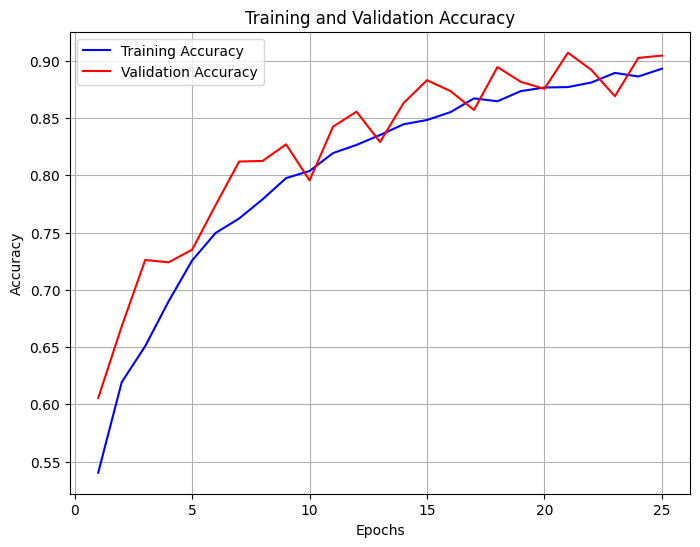

In [27]:
plot_accuracy(history_test_reduced)